In [2]:
#load in the libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, plot_partial_dependence
from matplotlib.pyplot import figure
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from nested_cv import NestedCV
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost.sklearn import XGBRegressor
from sklearn.inspection import PartialDependenceDisplay
import pickle

#ignore warnings if you want
import warnings
warnings.filterwarnings("ignore")

In [6]:
#make function to match the status for what ever parasite it is, binarize it, and drop unnecessary columns
def gettrain(df, parasite):
    #matching the sandfly status for the species of parasite to the sandfly in the larger dataframe
    for j in range(len(df)):
        for i in range(len(status)):
            if df.loc[j, 'species'] == status.loc[i, 'species']:
                df.loc[j, parasite] = status.loc[i, parasite]
    #fill the remaining vector status column with 0s, then binarize the status
    df[parasite] = df[parasite].fillna(0).map(lambda x : x//2)
    #set the index as the species name
    train = df.set_index('species')
    #drop unnecessary columns
    train = train.drop(columns=['Unnamed: 0', '.imp', '.id'])
    if 'index' in df.columns:
        train = train.drop(columns=['index'])
    
    return train

In [7]:
#code taken from https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d
#use the bootstrap methos to make make a confidence interval
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

# print the averages and the confidence interval
def getconf_interval(data):
    # Draw 15000 bootstrap replicates
    bs_replicates_aucs = draw_bs_replicates(data,np.mean,15000)

    # Print empirical mean
    print("Empirical mean: " + str(round(np.mean(data), 3)))

    # Print the mean of bootstrap replicates
    print("Bootstrap replicates mean: " + str(round(np.mean(bs_replicates_aucs), 3)))

    # Get the corresponding values of 2.5th and 97.5th percentiles
    conf_interval = np.percentile(bs_replicates_aucs,[2.5,97.5])

    # Print the interval
    print("The confidence interval: ", np.round(conf_interval, 3))


# return the confidence interval
def getconf_interval_var(data):
    # Draw 15000 bootstrap replicates
    bs_replicates_aucs = draw_bs_replicates(data,np.mean,15000)

    # Get the corresponding values of 2.5th and 97.5th percentiles
    conf_interval = np.percentile(bs_replicates_aucs,[2.5,97.5])
    
    return conf_interval

#takes in modelslist created in the predtable function, returns dataframe of variables and importances
def var_impt(list_of_models):

    impt_matrix = pd.DataFrame(list_of_models[0].feature_importances_, original_clean.columns[0:82])
    for x in range(1, len(list_of_models)):
        var_array = pd.DataFrame(list_of_models[x].feature_importances_, original_clean.columns[0:82])
        impt_matrix[x] = var_array[0]
        
    var_impt_df = pd.DataFrame()
    var_impt_df['feature'] = original_clean.columns[0:82]
    var_impt_df = var_impt_df.set_index('feature')
    for var in original_clean.columns[0:82]:
        mean = impt_matrix.loc[var].mean()
        var_impt_df.loc[var, 'importance'] = mean
        std = impt_matrix.loc[var].std()
        var_impt_df.loc[var, 'std'] = std

    var_impt_df = var_impt_df.reset_index()
    
    return impt_matrix, var_impt_df.round(3).sort_values(by='importance', ascending=False)

In [8]:
def getstatus(df, parasite):
    for i in range(len(status)):
        for j in range(len(df)):
            if status.loc[i, 'species'] == df.loc[j, 'species']:
                df.loc[j, 'potential/proven'] = status.loc[i, parasite]
    df = df.fillna(0)
    return df

In [10]:
original = pd.read_csv('raw data/one hot encoded original data.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia', 'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana','Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname', 'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('raw data/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species')
#drop unnecessary columns
original_clean = original.drop(columns=['Unnamed: 0'])

####LOOK AT CORRELLATED VARIABLES
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'

#wing_width / hs.canopy
#wing_width / hs.floor
#labruml_wingl / log.labrum.length
#log.grass.cover / log.shrub.cover
#domestic / intra
#temp / wing.width
#log.elevation / temp
#log.temp.var / temp.range
#maxshape_sabre / genus_Brumptomyia
#log.dental.depth / log.labrum.length


# pd.DataFrame(original_clean.corr()).to_csv('correllation.csv')
original_clean = original_clean.drop(columns=['subtribe_Sergentomyiina', 'subtribe_Brumptomyiina',
                                              'peri', 'subtribe_Hertigiina', 'tribe_Hertigiini',
                                              'wing.width', 'labruml_wingl', 'log.shrub.cover',
                                              'intra', 'log.elevation', 'log.temp.var', 'maxshape_sabre', 'log.dental.depth'])

In [11]:
original_clean['leish'].value_counts()

0.0    442
1.0     70
Name: leish, dtype: int64

In [12]:
#REMOVE THE BITES MAN COLUMN FOR THE MOST CONSERVATIVE ANALYSIS
original_clean = original_clean.drop(columns=['bites.man'])

### hyper parameter search

In [28]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > np.mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

secondary_parameters = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        secondary_parameters.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [30]:
### get out a list *secondary_parameters* that has the parameters and aucs

for i in range(100):
    data = original_clean
    do_nested_cv(data)

100%|█████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 0.23187817808070973]
Final Test Score is 0.7804975922953451
best = {'a': 0, 'colsample_bytree': 0.8218078130380093, 'gamma': 11.028966192600194, 'learning_rate': 0.5510671071473894, 'max_depth': 8.870018198441361, 'n_estimators': 124.91753406351626, 'scale_pos_weight': 11.067512912532399}
100%|██████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: 0.2212755598831548]
Final Test Score is 0.692215088282504
best = {'a': 0, 'colsample_bytree': 0.7819193696336103, 'gamma': 20.10608810901047, 'learning_rate': 0.5373056461576269, 'max_depth': 2.7361845022642477, 'n_estimators': 126.17515962925826, 'scale_pos_weight': 5.348255163549581}
100%|█████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15trial/s, best loss: 0.28930001081899814]
Final Test Score is 0.823836276083467
best = {'a': 0, 'colsample_bytree': 0.5009043227003589, 'gamma': 1

100%|█████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32trial/s, best loss: 0.26104890187168667]
Final Test Score is 0.7937399678972713
best = {'a': 0, 'colsample_bytree': 0.7799351764769067, 'gamma': 14.761252691740863, 'learning_rate': 0.8591232363079689, 'max_depth': 9.274527207029102, 'n_estimators': 192.96261475882812, 'scale_pos_weight': 6.58770328801789}
100%|██████████████████████████████████████████████| 100/100 [01:31<00:00,  1.09trial/s, best loss: 0.2443065022178946]
Final Test Score is 0.8049759229534511
best = {'a': 0, 'colsample_bytree': 0.5110779189009855, 'gamma': 11.068147132840378, 'learning_rate': 0.4731549351384525, 'max_depth': 6.645779773870967, 'n_estimators': 194.50828674248956, 'scale_pos_weight': 5.85168586271757}
100%|█████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11trial/s, best loss: 0.22694201016985824]
Final Test Score is 0.8912520064205457
best = {'a': 0, 'colsample_bytree': 0.46457997636225457, 'gamma': 1

100%|█████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22trial/s, best loss: 0.31753759601860876]
Final Test Score is 0.7937399678972713
best = {'a': 0, 'colsample_bytree': 0.5583085616278095, 'gamma': 13.429877375898132, 'learning_rate': 0.04005293686140421, 'max_depth': 4.383770869016719, 'n_estimators': 119.74371877265942, 'scale_pos_weight': 12.288962226643875}
100%|███████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.228483717407768]
Final Test Score is 0.71669341894061
best = {'a': 0, 'colsample_bytree': 0.4845236065846533, 'gamma': 39.94757867258832, 'learning_rate': 0.5814882463312112, 'max_depth': 4.332820955137125, 'n_estimators': 183.64230960017125, 'scale_pos_weight': 13.276866680191791}
100%|██████████████████████████████████████████████| 100/100 [01:34<00:00,  1.05trial/s, best loss: 0.3287758303581088]
Final Test Score is 0.8182182985553772
best = {'a': 0, 'colsample_bytree': 0.7462242020775454, 'gamma': 

100%|█████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29trial/s, best loss: 0.26211727794006273]
Final Test Score is 0.829454253611557
best = {'a': 0, 'colsample_bytree': 0.7117324844244362, 'gamma': 10.717810016130331, 'learning_rate': 0.43811081747971836, 'max_depth': 2.539688948985065, 'n_estimators': 166.51540528010497, 'scale_pos_weight': 8.702176427539793}
100%|█████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29trial/s, best loss: 0.32485394352482966]
Final Test Score is 0.8595505617977528
best = {'a': 0, 'colsample_bytree': 0.5914486017234994, 'gamma': 16.55709943221668, 'learning_rate': 0.49706843364046793, 'max_depth': 3.5633923889719497, 'n_estimators': 109.88303886656615, 'scale_pos_weight': 11.024509073685252}
100%|██████████████████████████████████████████████| 100/100 [01:13<00:00,  1.37trial/s, best loss: 0.2642269825814129]
Final Test Score is 0.6809791332263242
best = {'a': 0, 'colsample_bytree': 0.7991599186907741, 'gamma'

In [31]:
# create a binary pickle file 
f = open("secondary model/parameters.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(secondary_parameters,f)

# close file
f.close()

In [32]:
secondary_parameters = pd.read_pickle(r'secondary model/parameters.pkl')

In [33]:
print(len(secondary_parameters))
secondary_parameters

300


[({'a': 0,
   'colsample_bytree': 0.8218078130380093,
   'gamma': 11.028966192600194,
   'learning_rate': 0.5510671071473894,
   'max_depth': 8.870018198441361,
   'n_estimators': 124.91753406351626,
   'scale_pos_weight': 11.067512912532399},
  0.7803300624442462),
 ({'a': 0,
   'colsample_bytree': 0.9724604786686439,
   'gamma': 17.669806068090168,
   'learning_rate': 0.678146799525188,
   'max_depth': 9.488376380783624,
   'n_estimators': 156.74489707445983,
   'scale_pos_weight': 12.825190865180572},
  0.7556497175141244),
 ({'a': 0,
   'colsample_bytree': 0.621232182449577,
   'gamma': 12.00021012535151,
   'learning_rate': 0.07993867241613517,
   'max_depth': 4.858949096741536,
   'n_estimators': 131.2352449990375,
   'scale_pos_weight': 11.426114432402134},
  0.7060278902384166),
 ({'a': 0,
   'colsample_bytree': 0.7819193696336103,
   'gamma': 20.10608810901047,
   'learning_rate': 0.5373056461576269,
   'max_depth': 2.7361845022642477,
   'n_estimators': 126.17515962925826,
  

In [37]:
# take these parameters to R
param_top_ten = sorted(secondary_parameters, key = lambda x: x[1])[-10:]
params = [a[0] for a in param_top_ten]
param_df = pd.DataFrame(params).drop(columns = ['a'])
param_df.to_csv('secondary model/top 10 parameters.csv')

### parameter evaluation

In [38]:
####
#FOR EACH OF THE 10 BEST PERFORMING PARAMETERS IN ORIGINAL_MODELS, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = param_top_ten
auc_list = []
data = original_clean

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(**params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss', use_label_encoder=False)

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > np.mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

#         print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
#         plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

# ax.get_legend().remove()
# print(auc_list)
print('median AUC: ' + str(np.median(auc_list)))
print('mean AUC: ' + str(np.mean(auc_list)))

median AUC: 0.8689807383627608
mean AUC: 0.8668178170144462


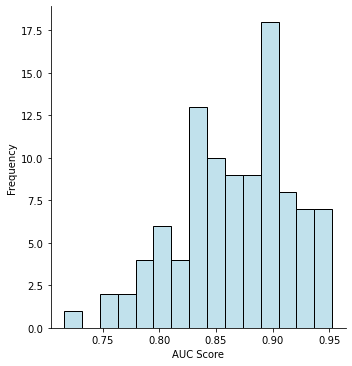

In [39]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 15, color='lightblue')
plt.xlabel('AUC Score')
plt.ylabel('Frequency')
# plt.title('Nested Cross Validation AUC Scores', fontsize = 15)

#median = 0.882
#mean = 0.880
plt.savefig('secondary model/secondary auc scores')

In [40]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = original_clean
param_dict = sorted(param_top_ten, key = lambda x: x[1])[-10:]
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list_proven = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': int(param_dict[x][0]['n_estimators']),
                              'scale_pos_weight': int(param_dict[x][0]['scale_pos_weight']), 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(**params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss', use_label_encoder=False)
        model.fit(X_train, y_train)
        
        models_list_proven.append(model)

        #predictions in an array
        y = model.predict_proba(X)

        #match prediction to the species for this split
        probability_table = X.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

In [50]:
#get a prediction table with the median probability and percentile for each species
prediction_matrix['std'] = pd.DataFrame(prediction_matrix.std(axis=1))
prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.median(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)

#these are the sandflies where the probability its a vector is greater than 0.5
#top_predictions = top_predictions[top_predictions['probability'] >= 0.5].reset_index(drop=True)

#get the important stats only
top_predictions = top_predictions[['species', 'probability','std', 'percentile']].reset_index(drop=True)

#add real labels
status = pd.read_csv('raw data/sandfly status.csv')
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions = final_predictions.round(3)
final_predictions

,species,probability,std,percentile,potential/proven
0,Bichromomyia flaviscutellata,0.977,0.098,1.000,2.0
1,Nyssomyia whitmani,0.968,0.096,0.998,2.0
2,Lutzomyia (Lutzomyia) longipalpis,0.967,0.096,0.996,2.0
3,Nyssomyia intermedia,0.966,0.096,0.994,2.0
4,Pintomyia (Pintomyia) fischeri,0.963,0.097,0.992,2.0
...,...,...,...,...,...
507,Psathyromyia maya,0.054,0.030,0.010,0.0
508,Trichopygomyia trichopyga,0.052,0.043,0.008,0.0
509,Psathyromyia (Forattiniella) coutinhoi,0.050,0.028,0.006,0.0
510,Brumptomyia pentacantha,0.043,0.030,0.004,0.0


In [51]:
#save the final predictions
final_predictions.to_csv("secondary model/secondary predictions.csv")

In [86]:
#get numbers for proportion figure below
proven = final_predictions[final_predictions['potential/proven'] == 2]
proven['probability']

0      0.977
1      0.968
2      0.967
3      0.966
4      0.963
7      0.956
8      0.950
9      0.949
10     0.946
11     0.943
12     0.942
14     0.937
17     0.933
18     0.932
19     0.929
20     0.928
21     0.925
22     0.924
25     0.917
26     0.916
27     0.910
29     0.903
32     0.895
34     0.890
37     0.875
39     0.862
40     0.849
45     0.820
46     0.803
47     0.802
48     0.793
49     0.792
51     0.789
52     0.786
59     0.735
70     0.651
106    0.547
Name: probability, dtype: float64

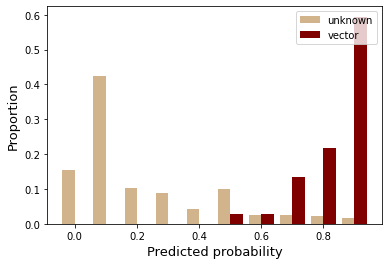

In [129]:
#make a histogram of predicted probabilities, scaled by proportion, like in han et al 2019
nonconfirmed_probs = final_predictions[final_predictions['potential/proven']!=2]['probability']
#found these values by hand
nonconfirmed_hist = [74., 201.,  49.,  42.,  20.,  47.,   12.,   12.,   10.,   8.]
confirmed_hist = [0.,  0.,  0.,  0.,  0.,  1.,  1.,  5.,  8., 22.]
nonconfirmed_hist = nonconfirmed_hist/np.sum(nonconfirmed_hist)
confirmed_hist = confirmed_hist/np.sum(confirmed_hist)

fig = plt.figure()
ax = plt.subplot(111)
plt.rcParams["figure.figsize"] = (6, 4)

width = 0.04
x = np.arange(0, 1, 0.1)
plt.bar(x-width/2, nonconfirmed_hist, width = width, color = 'tan')
plt.bar(x+width/2, confirmed_hist, width = width, color = 'maroon')

plt.legend(["unknown", "vector"], loc ="upper right")
plt.xlabel('Predicted probability', size = 13)
plt.ylabel('Proportion', size = 13)
plt.savefig('secondary model/probability distribution')

### predictions to tables

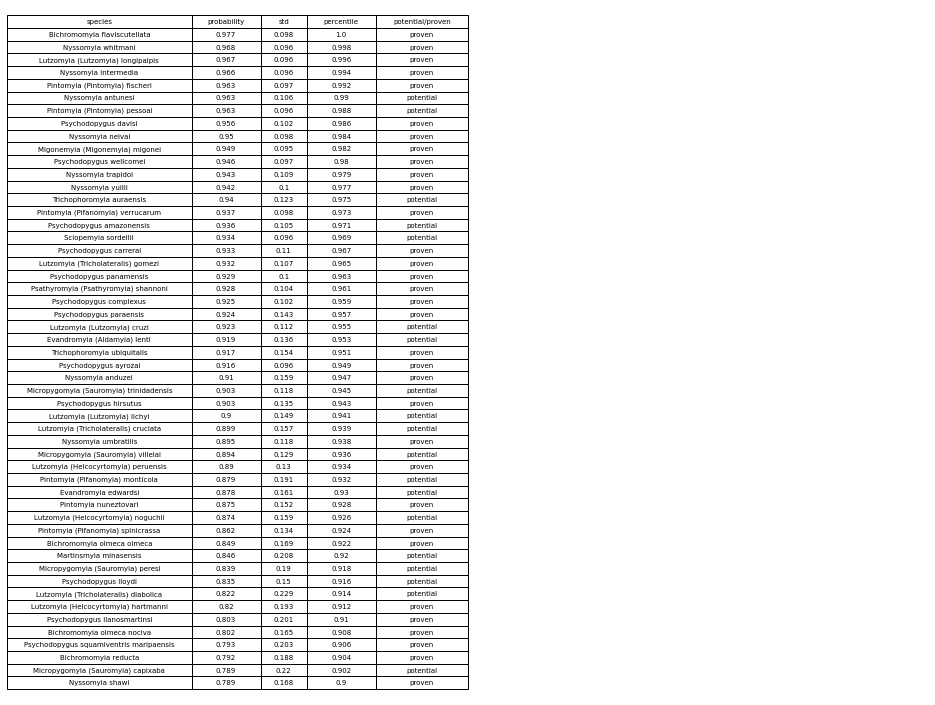

In [60]:
from matplotlib.backends.backend_pdf import PdfPages
fig, ax =plt.subplots(figsize=(8,12))
# ax.axis('tight')
ax.axis('off')
top_predictions = final_predictions.head(52) #these are the sandflies with above 0.5 

#reqrite the infection status columns
top_predictions.loc[top_predictions['potential/proven'] == 1.0, 'potential/proven'] = 'potential'
top_predictions.loc[top_predictions['potential/proven'] == 2.0, 'potential/proven'] = 'proven'
top_predictions.loc[top_predictions['potential/proven'] == 0.0, 'potential/proven'] = 'unknown'

the_table = ax.table(cellText=top_predictions.values,colLabels=top_predictions.columns,loc='left', cellLoc = 'center',
                     colWidths=[0.4, 0.15, 0.1, 0.15, 0.2])


#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("secondary model/top 52 predictions.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [61]:
#get the nonvector sandflies
#rewrite the infection status column
non_proven_predictions = final_predictions[final_predictions['potential/proven'] != 2].reset_index(drop=True)
non_proven_predictions.loc[non_proven_predictions['potential/proven'] == 1.0, 'potential/proven'] = 'potential'
non_proven_predictions.loc[non_proven_predictions['potential/proven'] == 2.0, 'potential/proven'] = 'proven'
non_proven_predictions.loc[non_proven_predictions['potential/proven'] == 0.0, 'potential/proven'] = 'unknown'
non_proven_predictions.rename(columns = {'potential/proven':'infection status'}, inplace = True)
non_proven_predictions = non_proven_predictions[['species', 'probability', 'std', 'percentile', 'infection status']]

In [132]:
non_proven_predictions[non_proven_predictions['species'] == 'Psychodopygus guyanensis']['probability']

20    0.761
Name: probability, dtype: float64

In [66]:
#get only the predicted ones above percentile 0.9
non_proven_top = non_proven_predictions[non_proven_predictions['percentile'] >= 0.9]

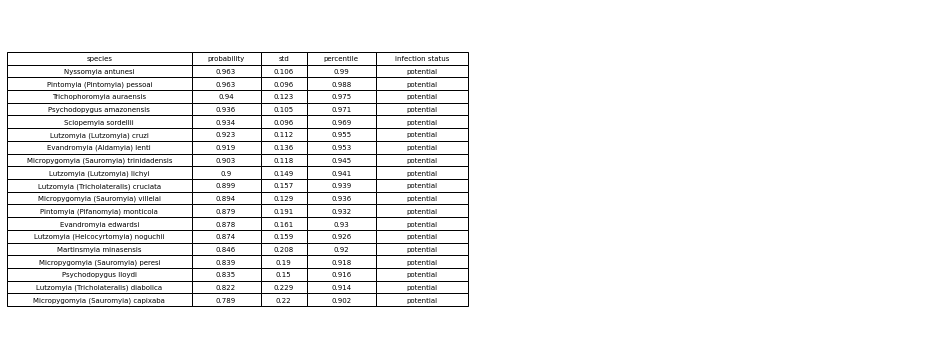

In [67]:
from matplotlib.backends.backend_pdf import PdfPages

fig, ax =plt.subplots(figsize=(8,6))
# ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=non_proven_top.values,colLabels=non_proven_top.columns,loc='left', cellLoc = 'center',
                     colWidths=[0.4, 0.15, 0.1, 0.15, 0.2])

pp = PdfPages("secondary model/non proven top predictions.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [71]:
non_proven_predictions.to_csv("secondary model/non proven predictions.csv")

### variable importance

In [72]:
#takes in modelslist created in the predtable function, returns dataframe of variables and importances
def var_impt(list_of_models):

    impt_matrix = pd.DataFrame(list_of_models[0].feature_importances_, original_clean.columns[0:81])
    for x in range(1, len(list_of_models)):
        var_array = pd.DataFrame(list_of_models[x].feature_importances_, original_clean.columns[0:81])
        impt_matrix[x] = var_array[0]
        
    var_impt_df = pd.DataFrame()
    var_impt_df['feature'] = original_clean.columns[0:81]
    var_impt_df = var_impt_df.set_index('feature')
    for var in original_clean.columns[0:81]:
        mean = impt_matrix.loc[var].mean()
        var_impt_df.loc[var, 'importance'] = mean
        std = impt_matrix.loc[var].std()
        var_impt_df.loc[var, 'std'] = std

    var_impt_df = var_impt_df.reset_index()
    
    return impt_matrix, var_impt_df.round(3).sort_values(by='importance', ascending=False)

In [73]:
var_impt_conf = var_impt(models_list_proven)[1]
var_impt_conf['lower'] = var_impt_conf['importance'] - 1.96 * var_impt_conf['std'] / 10
var_impt_conf['higher'] = var_impt_conf['importance'] + 1.96 * var_impt_conf['std'] / 10

In [75]:
var_impt_conf.reset_index(drop=True).to_csv("secondary model/variable importance 82.csv")

In [77]:
var_impt_conf = pd.read_csv("secondary model/variable importance 82.csv")
var_impt_conf.head(20)

,feature,importance,std,lower,higher
0,log(ecoregion breadth),0.089,0.092,0.070968,0.107032
1,semidomestic,0.060,0.037,0.052748,0.067252
2,log(crops cover),0.054,0.085,0.037340,0.070660
3,spear shape of maxillary tip,0.050,0.041,0.041964,0.058036
4,log(citations),0.047,0.021,0.042884,0.051116
5,Pintomyia genus,0.039,0.018,0.035472,0.042528
6,main habitat: annexes of domestic animals,0.037,0.021,0.032884,0.041116
7,Bichromomyia genus,0.036,0.015,0.033060,0.038940
8,temperature,0.035,0.036,0.027944,0.042056
9,global human modification,0.032,0.046,0.022984,0.041016


In [82]:
'''
citations - red
morphology - lightblue
taxonomy - grey
biogeography/ecology - lightgreen
'''
c = 'red'
m = 'deepskyblue'
t = 'black'
b = 'limegreen'
color_list = [b, b, b, m, c,
             t, b, t, b, b,
              b, m, m, b, b,
              m, t, b, m, b]


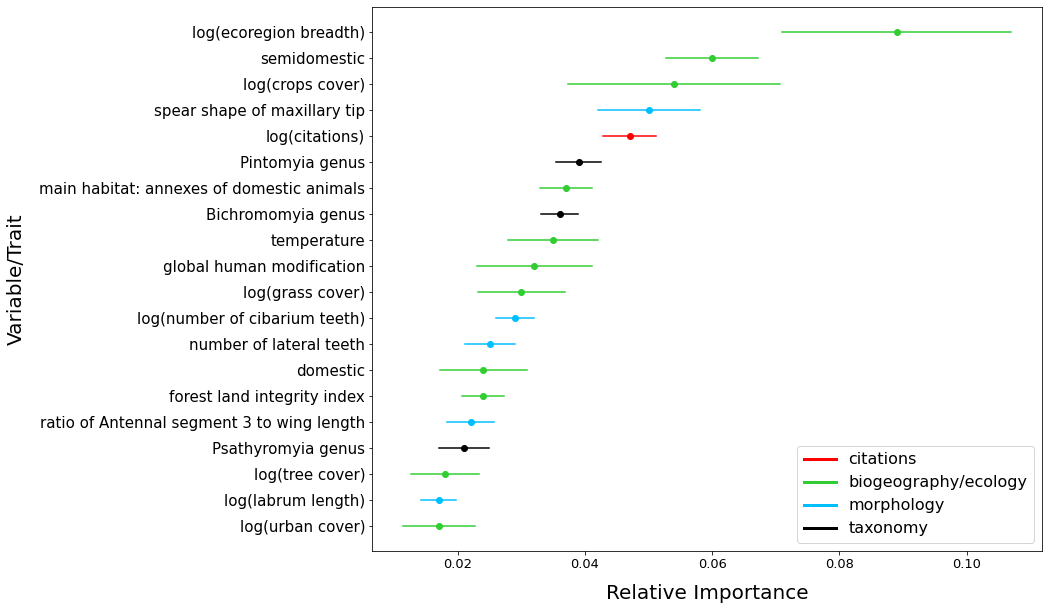

In [83]:
# for the top 10, with categorical variables summed:
fig, ax = plt.subplots()

# plot the importances with their confidence intervals
x = var_impt_conf.head(20)['feature'].to_list()
y = var_impt_conf.head(20)['importance'].to_list()

for num in range(20):
    plt.scatter(y[num], x[num], c = color_list[num])
# plt.scatter(y, x, c = "lightgrey")
plt.yticks(fontsize=15)
plt.xticks(fontsize=13)

#plot the lower and upper confidence interval
for lower,upper,y in zip(var_impt_conf['lower'].head(20), var_impt_conf['higher'].head(20),
                         range(len(color_list))):
    plt.plot((lower,upper),(y,y), color=color_list[y])

#fix the axes naming and size
plt.rcParams["figure.figsize"] = (12,10)
plt.xlabel("Relative Importance", labelpad=13, fontsize = 20)
plt.ylabel('Variable/Trait', labelpad = 13, fontsize = 20)
plt.rc('axes', titlesize=20) #axes font size
plt.gca().invert_yaxis()

from matplotlib.lines import Line2D
#plot the legend
custom_lines = [Line2D([0], [0], color='red', lw=3),
                Line2D([0], [0], color='limegreen', lw=3),
                Line2D([0], [0], color='deepskyblue', lw=3),
               Line2D([0], [0], color='black', lw=3)]
#give the legend lines names
ax.legend(custom_lines, ['citations', 'biogeography/ecology', 'morphology', 'taxonomy'],
          loc = 'lower right', fontsize = 16)

plt.savefig('secondary model/top 20 features scatterplot.png', bbox_inches='tight')

### summing the categorical variables

In [175]:
#from this variable importance dataframe, we can sum up the categorical variables into a new dataframe. i did this by hand:
var_impt_sum = pd.read_csv("secondary model/variable importance sum.csv")

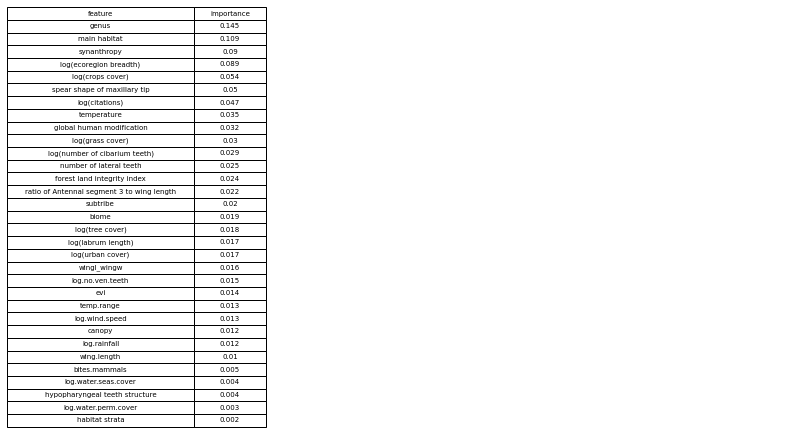

In [176]:
#for the table, get only the feature and importance
var_impt_sum_1 = var_impt_sum[['feature', 'importance']]

fig, ax =plt.subplots(figsize=(9,6))
# ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=var_impt_sum_1.values,colLabels=var_impt_sum_1.columns,loc='left', cellLoc = 'center',
                     colWidths=[0.36, 0.14, 0.1])
the_table.auto_set_font_size(False)
the_table.set_fontsize(7)


#https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
pp = PdfPages("secondary model/variable importance sum.pdf")
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
pp.savefig(fig, bbox_inches='tight')
pp.close()

In [139]:
'''
citations - red
morphology - lightblue
taxonomy - grey
biogeography/ecology - lightgreen
'''
c = 'red'
m = 'deepskyblue'
t = 'black'
b = 'limegreen'
color_list_2 = [t, b, b, b, b, m, c, b, b, b]

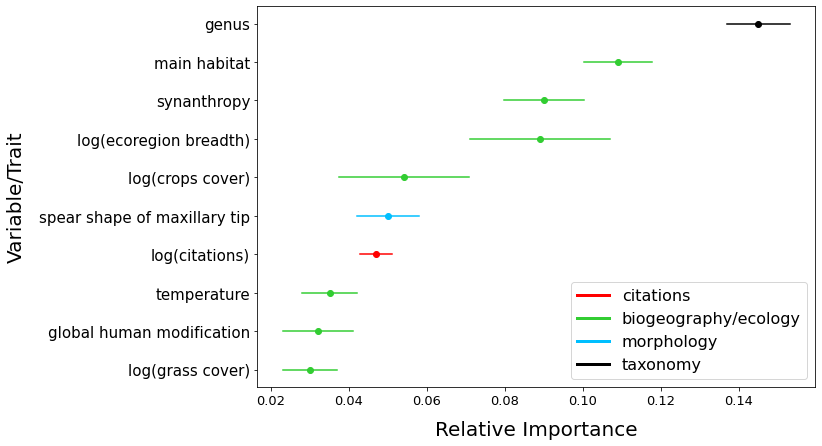

In [140]:
# for the top 10, with categorical variables summed:
fig, ax = plt.subplots()

# plot the importances with their confidence intervals
x = var_impt_sum.head(10)['feature'].to_list()
y = var_impt_sum.head(10)['importance'].to_list()

for num in range(len(color_list_2)):
    plt.scatter (y[num], x[num], c = color_list_2[num])
# plt.scatter(y, x, c = "lightgrey")
plt.yticks(fontsize=15)
plt.xticks(fontsize=13)

#plot the lower and upper confidence interval
for lower,upper,y in zip(var_impt_sum['lower'].head(10), var_impt_sum['higher'].head(10),
                         range(len(var_impt_sum))):
    plt.plot((lower,upper),(y,y), color=color_list_2[y])

#fix the axes naming and size
plt.rcParams["figure.figsize"] = (10,7)
plt.xlabel("Relative Importance", labelpad=13, fontsize = 20)
plt.ylabel('Variable/Trait', labelpad = 13, fontsize = 20)
plt.rc('axes', titlesize=20) #axes font size
plt.gca().invert_yaxis()

#plot the legend
custom_lines = [Line2D([0], [0], color='red', lw=3),
                Line2D([0], [0], color='limegreen', lw=3),
                Line2D([0], [0], color='deepskyblue', lw=3),
               Line2D([0], [0], color='black', lw=3)]
#give the legend lines names
ax.legend(custom_lines, ['citations', 'biogeography/ecology', 'morphology', 'taxonomy'],
          loc = 'lower right', fontsize = 16)

plt.savefig('secondary model/top 10 summed features scatterplot.png', bbox_inches='tight')

## partial dependence plots

In [147]:
data = original_clean
X, y = data.iloc[:,:-1], data.iloc[:,-1]
data.to_csv("secondary model/partial dependence/trait data.csv")

In [145]:
data['leish'].value_counts()

0.0    442
1.0     70
Name: leish, dtype: int64

In [5]:
##load all the csvs
Bichromomyia = pd.read_csv('secondary model/partial dependence data/Bichromomyia.csv')
Pintomyia = pd.read_csv('secondary model/partial dependence data/Pintomyia.csv')
domestic = pd.read_csv('secondary model/partial dependence data/domestic.csv')
mh_ada = pd.read_csv('secondary model/partial dependence data/mh_ada.csv')
semidomestic = pd.read_csv('secondary model/partial dependence data/semidomestic.csv')
maxshape_spear = pd.read_csv('secondary model/partial dependence data/maxshape_spear.csv')

#continuous variables - rows are not the same length, so we add a names parameter
citations = pd.read_csv('secondary model/partial dependence data/citations.csv',names=list(range(26)))
crops_cover = pd.read_csv('secondary model/partial dependence data/crops_cover.csv',
                          names=list(range(pd.read_csv('secondary model/partial dependence data/crops_cover.csv').shape[1])))
ecoregion = pd.read_csv('secondary model/partial dependence data/ecoregion.csv', names=list(range(16)))

grass_cover = pd.read_csv('secondary model/partial dependence data/grass_cover.csv',
                       names=list(range(pd.read_csv('secondary model/partial dependence data/grass_cover.csv').shape[1])))
ghm = pd.read_csv('secondary model/partial dependence data/ghm.csv',
                  names=list(range(pd.read_csv('secondary model/partial dependence data/ghm.csv').shape[1])))
flii = pd.read_csv('secondary model/partial dependence data/flii.csv',
                   names=list(range(pd.read_csv('secondary model/partial dependence data/flii.csv').shape[1])))

lateral = pd.read_csv('secondary model/partial dependence data/lateral.csv', names=list(range(35)))
no_cib = pd.read_csv('secondary model/partial dependence data/no.cib.teeth.csv',names=list(range(11)))
temp = pd.read_csv('secondary model/partial dependence data/temp.csv',
                   names=list(range(pd.read_csv('secondary model/partial dependence data/temp.csv').shape[1])))

A3_wingl = pd.read_csv('secondary model/partial dependence data/A3_wingl.csv', names=list(range(12)))

In [6]:
#binary variables
binary_df = [semidomestic, maxshape_spear, Pintomyia, mh_ada, Bichromomyia, domestic]
#cont variables with same length rows
variable_dfs_1 = [crops_cover, temp, grass_cover, ghm, flii]
#cont variables with not same length rows
variable_dfs_2 = [ecoregion, citations, no_cib, lateral, A3_wingl]

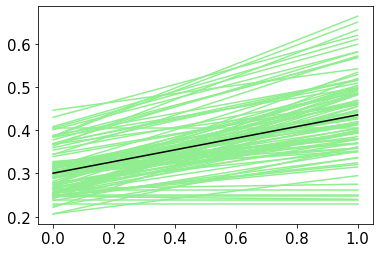

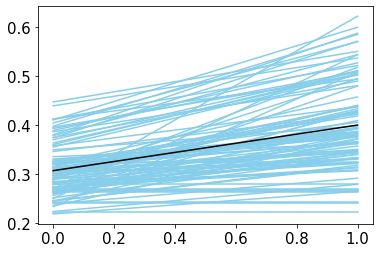

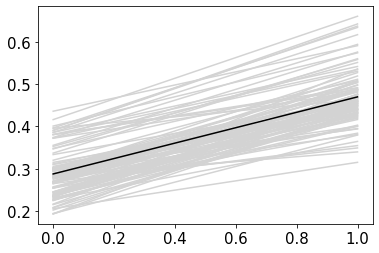

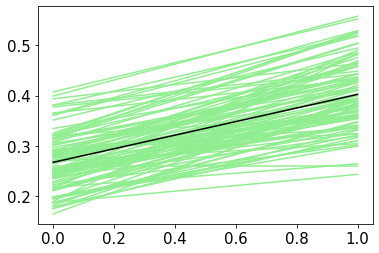

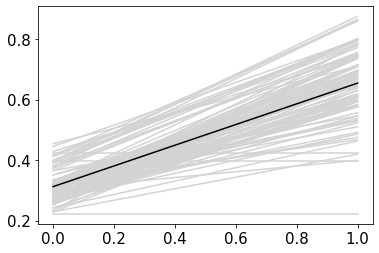

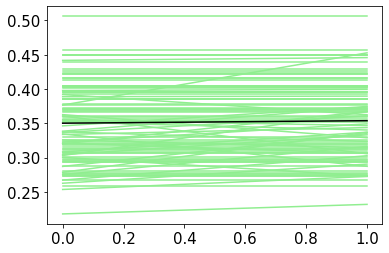

In [7]:
#binary variables: semidomestic, maxshape_spear, Pintomyia,
#mh_ada, Bichromomyia, domestic
'''
citations - red
morphology - lightblue
taxonomy - grey
biogeography/ecology - lightgreen
'''
c = 'red'
m = 'skyblue'
t = 'lightgrey'
b = 'lightgreen'
colors_list = [b, m, t, b, t, b]
for d in range(len(binary_df)):
    fig = plt.figure()
    ax = plt.subplot(111)
    
    color = colors_list[d]
    data = binary_df[d].iloc[:,1:]
    x_axis = data.iloc[:,0]
    
    for x in range(100):
        y_axis = data.iloc[:,x*2+1]
        modelx_plot = plt.plot(x_axis,y_axis, color = color)
        
    #get average line
    ax = plt.gca()
    line = ax.lines[0]
    x_array = line.get_xdata()

    y_array = ax.lines[0].get_ydata()
    for i in range(1, 100):
        y_array += ax.lines[i].get_ydata()
    y_array = y_array/100
    plt.plot(x_array, y_array, color = 'black')   
        
#     plt.xlabel(data.iloc[:,[0]].columns[0])
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.rcParams["figure.figsize"] = (6,4)

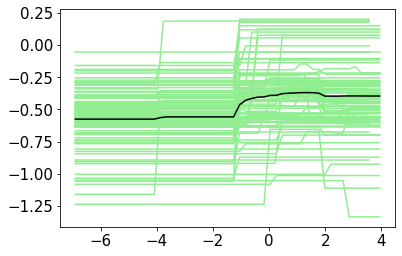

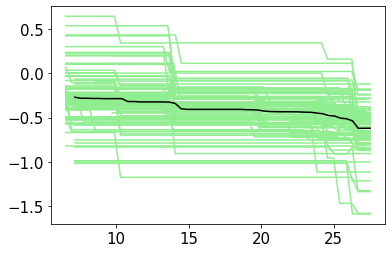

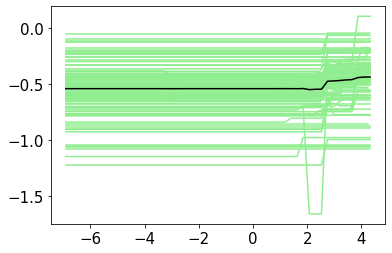

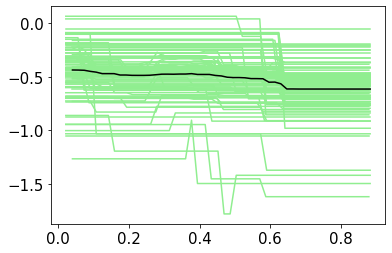

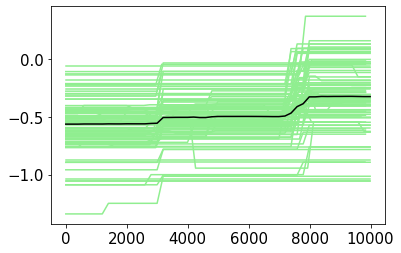

In [8]:
#continuous variables part 1
#crops_cover, temp, grass_cover, ghm, flii

'''
citations - red
morphology/genus - black
biogeo/ecology - green
'''

for df in variable_dfs_1:
    fig = plt.figure()
    ax = plt.subplot(111)
        
    data = df
    color = 'lightgreen'
    
    for x in range(100):
        x_axis = data.loc[x*2].dropna()[1:]
        y_axis = data.loc[x*2+1].dropna()[1:]
        modelx_plot = plt.plot(x_axis,y_axis, color = color)
        
    #get average line
    ax = plt.gca()
    line = ax.lines[0]
    x_array = line.get_xdata()

    y_array = ax.lines[0].get_ydata()
    for i in range(1, 100):
        y_array += ax.lines[i].get_ydata()
    y_array = y_array/100
    plt.plot(x_array, y_array, color = 'black')

#     plt.xlabel(data.loc[0][0])
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.rcParams["figure.figsize"] = (6,4)

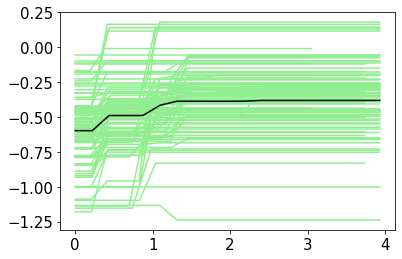

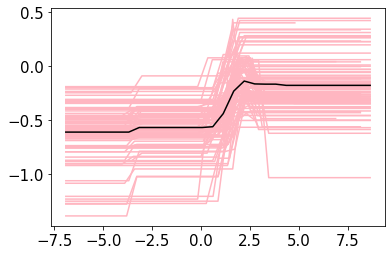

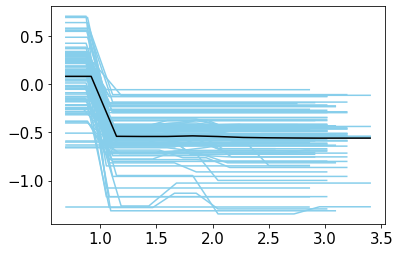

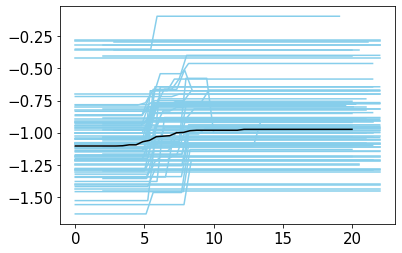

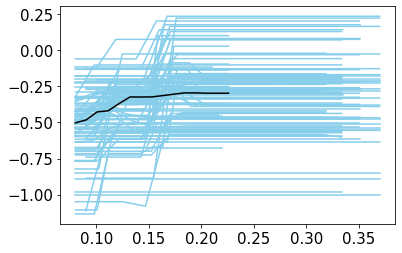

In [9]:
#continuous variables part 2
#ecoregion, citations, no_cib, lateral, A3_wingl

'''
citations - red
morphology - lightblue
taxonomy - grey
biogeography/ecology - lightgreen
'''
c = 'lightpink'
m = 'skyblue'
t = 'lightgrey'
b = 'lightgreen'

colors_list = [b, c, m, m, m]


for d in range(len(variable_dfs_2)):
    fig = plt.figure()
    ax = plt.subplot(111)

    data = variable_dfs_2[d].reset_index(drop=False)
    data.columns = range(data.columns.size)
    color = colors_list[d]

    for x in range(100):
        x_axis = data.loc[x*2].dropna()[1:]
        y_axis = data.loc[x*2+1].dropna()[1:]
        modelx_plot = plt.plot(x_axis,y_axis, color = color)

    length_list = []
    for x in range(100):
        length = len(data.loc[x*2].dropna()[1:])
        length_list.append(length)
    median_length = round(np.median(length_list))

    median_df = pd.DataFrame()
    for x in range(100):
        if len(data.loc[x*2].dropna()[1:])==median_length:
            median_df = median_df.append(data.loc[x*2].dropna()) 
            median_df = median_df.append(data.loc[x*2 + 1].dropna()) 

    median_df = median_df.reset_index(drop=True)
    median_df = median_df.iloc[:, 1:]
    x_ax = median_df.iloc[0]
    mean_df = pd.DataFrame()
    for i in range(len(median_df)//2):
        mean_df = mean_df.append(median_df.iloc[2*i + 1],ignore_index=True)

    y_avg = mean_df.mean(axis=0)

    plt.plot(x_ax, y_avg, color = 'black')


    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.rcParams["figure.figsize"] = (6,4)